In [ ]:
# --- Install Required Libraries ---
!pip install -q bitsandbytes accelerate transformers datasets peft sentence-transformers




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 813.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00


In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
# drive.mount('/content/drive')

# --- Imports ---
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load Model and Tokenizer ---
model_name = "google/gemma-7b"
output_dir = "/content/drive/MyDrive/gemma_lora_outputs/final_lora_adapter"
tokenizer_path = "/content/drive/MyDrive/gemma_lora_outputs/final_tokenizer"



In [ ]:
# Load base model and LoRA adapter
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    trust_remote_code=True
)

# Load LoRA fine-tuned weights
model = PeftModel.from_pretrained(model, output_dir)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, trust_remote_code=True)

# --- Generation Function ---



config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [ ]:
# --- Generation Function ---
def generate_text(prompt, max_new_tokens=250, temperature=0.7, top_p=0.9):
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True,
            # num_beams=5,
            repetition_penalty=1.2,
            length_penalty=1.5,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# --- Enhanced Prompting ---
leaders = [
    "Elder Neal A. Maxwell",
    "President Dieter F. Uchtdorf",
    "Elder Jeffrey R. Holland",
    "President Russell M. Nelson",
    "Elder David A. Bednar"
]

topics = ['faith','repentance']

def generate_leader_text(leader, topic):
    if leader not in leaders:
        raise ValueError(f"Leader '{leader}' not available. Choose from: {leaders}")
    prompt = f"Write a brief reflection on {topic} in the style of {leader}. Conclude with a single, clear message.."
    return generate_text(prompt)

# --- Batch Generation ---
def batch_generate(leader, topics):
    if isinstance(topics, str):
        topics = [topics]
    generations = {}
    for topic in topics:
        generations[topic] = generate_leader_text(leader, topic)
    return pd.DataFrame(list(generations.items()), columns=["Topic", "Generated Text"])


In [ ]:
batch_generate('President Russell M. Nelson', 'faith')

,Topic,Generated Text
0,faith,Write a brief reflection on faith in the style...


In [ ]:
# --- Validation: Semantic Similarity Analysis ---
model_st = SentenceTransformer('all-MiniLM-L6-v2')

# Example real samples (can be replaced with your own)
real_samples = [
    "Faith is not only a feeling; it is a decision. It is choosing to believe."
]

# Example generated outputs (can be replaced with your own)
generated_outputs = [
    generate_text("Write a quote about faith in the style of President Uchtdorf.")
]

# Compute embeddings
real_embeddings = model_st.encode(real_samples, convert_to_tensor=True)
gen_embeddings = model_st.encode(generated_outputs, convert_to_tensor=True)

# Compute cosine similarity
similarity_scores = util.cos_sim(gen_embeddings, real_embeddings)



modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

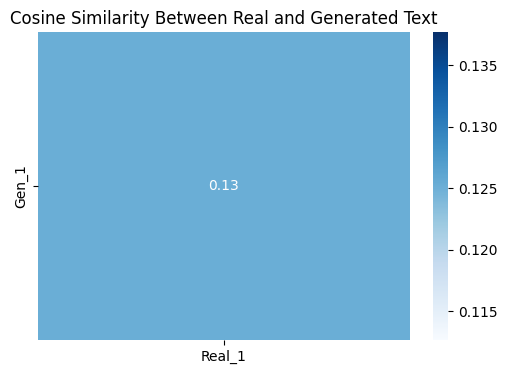

In [ ]:
# Display results
df = pd.DataFrame(
    similarity_scores.cpu().numpy(),
    columns=[f"Real_{i+1}" for i in range(len(real_samples))],
    index=[f"Gen_{i+1}" for i in range(len(generated_outputs))]
)

plt.figure(figsize=(6, 4))
sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Cosine Similarity Between Real and Generated Text")
plt.show()



In [ ]:
# Output Similarity
print("Average Similarity:", df.values.mean())

Average Similarity: 0.12515374
